# 목차
## 1. Library Import
## 2. 학습데이터 생성
## 3. Light-gbm 모델 훈련
## 4. 교차 검증 점수 확인
## 5. 제출 파일 생성

## 1. Library Import

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
# 모듈
import os, pathlib, glob
import random
from pytz import timezone # Colab 사용 시, Asia/Seoul로 지정 필요

In [3]:
# HDLY
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# HDLY
# 작업경로 변경
os.chdir('/content/gdrive/MyDrive/Colab/Dacon_LG_AUC')

print('Current directory: ', os.getcwd())

Current directory:  /content/gdrive/MyDrive/Colab/Dacon_LG_AUC


In [31]:
# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

## 2. 학습데이터 생성

#### 2.1. train_err

* train_err_data.csv 파일의 errtype column의 value_counts를 카운트하여 학습에 사용.
* 주어진 기간동안 user_id별로 peroblem가 한 번이라도 발생했는 지를 확인.

In [8]:
PATH = os.getcwd() + '/'

train_err = pd.read_csv(PATH+'train_err_data.csv')
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [9]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [10]:
print(np.sort(train_err.errtype.unique()))
# errtype이 1부터 42까지 29를 제외한 41개가 존재.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [11]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.

id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42))

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1] += 1
error.shape

100%|██████████| 16554663/16554663 [00:39<00:00, 414730.82it/s]


(15000, 42)

In [36]:
# HDLY

# train_err 시간 구하기

train_err             = pd.read_csv(PATH+'train_err_data.csv')
train_err['datetime'] = train_err['time'].apply(make_datetime)

min_day = train_err.datetime.min().date()

train_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day
train_err['days'] = train_err['days'].dt.days

train_err['hour'] = train_err.loc[:, 'datetime'].dt.time

display(train_err)

,user_id,time,model_nm,fwver,errtype,errcode,datetime,days,hour
0,10000,20201101025616,model_3,05.15.2138,15,1,2020-11-01 02:00:00,1,02:00:00
1,10000,20201101030309,model_3,05.15.2138,12,1,2020-11-01 03:00:00,1,03:00:00
2,10000,20201101030309,model_3,05.15.2138,11,1,2020-11-01 03:00:00,1,03:00:00
3,10000,20201101050514,model_3,05.15.2138,16,1,2020-11-01 05:00:00,1,05:00:00
4,10000,20201101050515,model_3,05.15.2138,4,0,2020-11-01 05:00:00,1,05:00:00
...,...,...,...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1,2020-11-30 16:00:00,30,16:00:00
16554659,24999,20201130172625,model_3,05.15.2138,16,1,2020-11-30 17:00:00,30,17:00:00
16554660,24999,20201130172625,model_3,05.15.2138,4,0,2020-11-30 17:00:00,30,17:00:00
16554661,24999,20201130172631,model_3,05.15.2138,4,0,2020-11-30 17:00:00,30,17:00:00


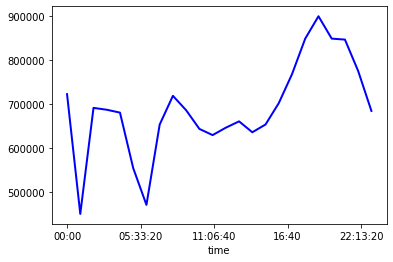

In [47]:
#  Train_err_data의 hour 분포 확인

col = 'hour'
#train_err[col].value_counts().sort_index() # 시간 별 err 수 카운트
train_err['hour'].value_counts().sort_index().plot(color='b', lw=2, label='train')
# train_err['time'].value_counts().sort_index().plot(color='r',  lw=2, label='test')

# fig = plt.figure(figsize=(20, 20))
# plt.legend()
# plt.xlabel("hour")
# plt.ylabel("# of rows")
# plt.title("Distribution of date in Train/Test-Quality");

In [43]:
# HDLY

# problem 시간 구하기

train_problem             = pd.read_csv(PATH+'train_problem_data.csv')
train_problem['datetime'] = train_problem['time'].apply(make_datetime)

min_day = train_problem.datetime.min().date()

train_problem['days'] = train_problem.loc[:,'datetime'].dt.date - min_day
train_problem['days'] = train_problem['days'].dt.days

train_problem['hour'] = train_problem.loc[:, 'datetime'].dt.time

display(train_problem)

,user_id,time,datetime,days,hour
0,19224,20201102200000,2020-11-02 20:00:00,1,20:00:00
1,23664,20201116140000,2020-11-16 14:00:00,15,14:00:00
2,15166,20201114130000,2020-11-14 13:00:00,13,13:00:00
3,12590,20201108210000,2020-11-08 21:00:00,7,21:00:00
4,15932,20201103210000,2020-11-03 21:00:00,2,21:00:00
...,...,...,...,...,...
5424,20167,20201125120000,2020-11-25 12:00:00,24,12:00:00
5425,16270,20201110120000,2020-11-10 12:00:00,9,12:00:00
5426,19114,20201106230000,2020-11-06 23:00:00,5,23:00:00
5427,21505,20201104110000,2020-11-04 11:00:00,3,11:00:00


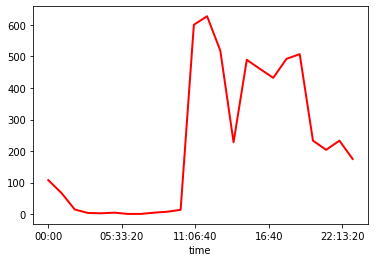

In [46]:
#  train_problem_data hour 분포 확인

col = 'hour'
#train_problem[col].value_counts().sort_index() # 시간 별 err 수 카운트
train_problem['hour'].value_counts().sort_index().plot(color='r', lw=2, label='train')

In [ ]:
id_error = train_err[['user_id','errtype','days']].values
error = np.zeros((train_user_number,42, 33))
for idx, err, days in tqdm(id_error):
    error[idx - train_user_id_min,err - 1, days] += 1
error.shape

100%|██████████| 16554663/16554663 [01:05<00:00, 253181.41it/s]


(15000, 42, 33)

#### 2.2. problem

In [ ]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1 
problem.shape

(15000,)

## 3. Light-gbm 모델 훈련

In [ ]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = error
train_y = problem
del error, problem
print(train_x.shape)
print(train_y.shape)

(15000, 42, 33)
(15000,)


In [ ]:
# Train

# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True

models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5

In [ ]:
# 파라미터 설정

# ref url. https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

params =      {
                'boosting_type' : 'dart',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015
                }

In [ ]:
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 2000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[200]	valid_0's auc: 0.802553	valid_0's pr_auc: 0.799102
[400]	valid_0's auc: 0.800252	valid_0's pr_auc: 0.793796
[600]	valid_0's auc: 0.797233	valid_0's pr_auc: 0.791374
[800]	valid_0's auc: 0.794428	valid_0's pr_auc: 0.789994
[1000]	valid_0's auc: 0.792123	valid_0's pr_auc: 0.788219
[1200]	valid_0's auc: 0.790824	valid_0's pr_auc: 0.787122
[1400]	valid_0's auc: 0.786919	valid_0's pr_auc: 0.785524
[1600]	valid_0's auc: 0.785297	valid_0's pr_auc: 0.785122
[1800]	valid_0's auc: 0.782444	valid_0's pr_auc: 0.784006
[2000]	valid_0's auc: 0.779536	valid_0's pr_auc: 0.782703
[200]	valid_0's auc: 0.806186	valid_0's pr_auc: 0.343844
[400]	valid_0's auc: 0.807478	valid_0's pr_auc: 0.342261
[600]	valid_0's auc: 0.807434	valid_0's pr_auc: 0.343819
[800]	valid_0's auc: 0.804217	valid_0's pr_auc: 0.33816
[1000]	valid_0's auc: 0.802428	valid_0's pr_auc: 0.34627
[1200]	valid_0's auc: 0.802221	valid_0's pr_auc: 0.340311
[1400]	valid_0's auc: 0.803084	valid_0's pr_auc: 0.333172
[1600]	valid_0's auc: 0.

## 4. 교차 검증 점수 확인

In [ ]:
print(np.mean(auc_scores))

0.7873375064848684


## 5. 제출 파일 생성

In [ ]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
display(test_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1


In [ ]:
# 데이터 설명을 확인하면
# test 데이터는 ueser_id가 30000부터 44998까지 총 14999개가 존재.
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [ ]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████| 16532648/16532648 [01:00<00:00, 272404.47it/s]

(14999, 42)


In [ ]:
# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

pred_ensemble

array([[0.86304892],
       [0.24459052],
       [0.22640172],
       ...,
       [0.56576105],
       [0.76814615],
       [0.42601461]])

In [ ]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

sample_submssion['problem'] = pred_ensemble.reshape(-1)

sample_submssion.to_csv("dacon_baseline.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.863049
1,30001,0.244591
2,30002,0.226402
3,30003,0.791338
4,30004,0.735666
...,...,...
14994,44994,0.223210
14995,44995,0.381821
14996,44996,0.565761
14997,44997,0.768146
